### Import thư viện

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
from pydicom import dcmread
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from supporters import *
from PIL import Image
import SimpleITK as sitk
import nibabel as nib
import tensorflow as tf
import pickle

### 1. Đọc và tiền xử lý ảnh file dcm

In [2]:
def load_scan(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)  
    return np.array(image, dtype=np.int16)

##### Load folder tất cả bệnh nhân và load 1 bệnh nhân 

In [3]:
INPUT_FOLDER = '../../data/PatientsDCM/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [39]:
PAT001_scan = load_scan(INPUT_FOLDER + patients[0])
PAT001 = get_pixels_hu(PAT001_scan)
PAT001.shape

(201, 512, 512)

In [ ]:
explore_3D_array(PAT001)

### 2. Thực Hiện Linear Regression để loại bỏ những tấm ảnh gây nhiễu (không chứa tim)

PAT001: 0 $\rightarrow$ 59 and 180 $\rightarrow$ 200

PAT002: 0 $\rightarrow$ 41 and 150 $\rightarrow$ 184

PAT003: 0 $\rightarrow$ 90 and 170 $\rightarrow$ 209

PAT004: 0 $\rightarrow$ 47 and 170 $\rightarrow$ 196

PAT005: 0 $\rightarrow$ 80 and 190 $\rightarrow$ 216

PAT006: 0 $\rightarrow$ 85 and 190 $\rightarrow$ 231

PAT007: 0 $\rightarrow$ 90 and 170 $\rightarrow$ 196

PAT008: 0 $\rightarrow$ 100 and 220 $\rightarrow$ 272

PAT009: 0 $\rightarrow$ 90 and 200 $\rightarrow$ 237

PAT010: 0 $\rightarrow$ 42 and 170 $\rightarrow$ 203

PAT011: 0 $\rightarrow$ 73 and 180 $\rightarrow$ 216

PAT012: 0 $\rightarrow$ 60 and 160 $\rightarrow$ 177

PAT013: 0 $\rightarrow$ 80 and 165 $\rightarrow$ 188

PAT014: 0 $\rightarrow$ 115 and 200 $\rightarrow$ 216

PAT015: 0 $\rightarrow$ 84 and 210 $\rightarrow$ 249

PAT016: 0 $\rightarrow$ 80 and 200 $\rightarrow$ 234

In [16]:
y1 = np.ones(201)
y1[0:60] = y1[180:201] = 0
y1 = pd.DataFrame(y1)

y2 = np.ones(185)
y2[0:41] = y2[150:185] = 0
y2 = pd.DataFrame(y2)

y3 = np.ones(210)
y3[0:90] = y3[170:210] = 0
y3 = pd.DataFrame(y3)

y4 = np.ones(197)
y4[0:47] = y4[170:197] = 0
y4 = pd.DataFrame(y4)

y5 = np.ones(217)
y5[0:80] = y5[190:217] = 0
y5 = pd.DataFrame(y5)

y6 = np.ones(231)
y6[0:85] = y6[190:231] = 0
y6 = pd.DataFrame(y6)

y7 = np.ones(197)
y7[0:90] = y7[170:197] = 0
y7 = pd.DataFrame(y7)

y8 = np.ones(273)
y8[0:100] = y8[220:273] = 0
y8 = pd.DataFrame(y8)

y9 = np.ones(238)
y9[0:90] = y9[200:238] = 0
y9 = pd.DataFrame(y9)

y10= np.ones(204)
y10[0:42] = y10[170:204] = 0
y10 = pd.DataFrame(y10)

y11 = np.ones(217)
y11[0:73] = y11[180:217] = 0
y11 = pd.DataFrame(y11)

y12 = np.ones(178)
y12[0:60] = y12[160:178] = 0
y12 = pd.DataFrame(y12)

y13 = np.ones(189)
y13[0:80] = y13[165:189] = 0
y13 = pd.DataFrame(y13)

y14 = np.ones(217)
y14[0:115] = y14[200:217] = 0
y14 = pd.DataFrame(y14)

y15 = np.ones(250)
y15[0:84] = y15[210:201] = 0
y15 = pd.DataFrame(y15)

y16 = np.ones(235)
y16[0:80] = y16[200:235] = 0
y16 = pd.DataFrame(y16)

In [17]:
y = pd.concat([y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16])
y.to_csv('../../data/PatientsDCM/Postprocessing/binary_training_label.csv', index=False)

In [4]:
y = pd.read_csv('../../data/PatientsDCM/Postprocessing/binary_training_label.csv')
y

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
3434,0.0
3435,0.0
3436,0.0
3437,0.0


In [11]:
# Load tất cả bộ ảnh của tất cả bệnh nhân và X_train
X = []

for i in range(0, 16, 1):
    PAT = load_scan(INPUT_FOLDER + patients[i])
    PAT = get_pixels_hu(PAT)
    for j in range(PAT.shape[0]):
        X.append(PAT[j])
    
X = np.array(X)
X.shape

(3439, 512, 512)

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2304, 512, 512), (1135, 512, 512), (2304, 1), (1135, 1))

#### 2.1 Huấn luyện mô hình với Logistic Regression của scikit-learn

In [21]:
from sklearn.linear_model import LogisticRegression

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Create a logistic regression object
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict the test set results
y_pred = logreg.predict(X_test)


d:\Documents\GitHub\VascuIAR\.venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Documents\GitHub\VascuIAR\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
# Đánh giá
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

def log_loss(y_true, y_pred):
    n = len(y_true)
    loss = -1/n * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

# Calculate loss
loss = log_loss(y_test, y_pred)

accuracy, loss

(0.9814977973568282, 0.6668869790056919)

d:\Documents\GitHub\VascuIAR\.venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11400\3235110471.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\Admin\AppData\Local\Temp\ipykernel_11400\3235110471.py:14: RuntimeWarning: divide by zero encountered in log
  J = (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))


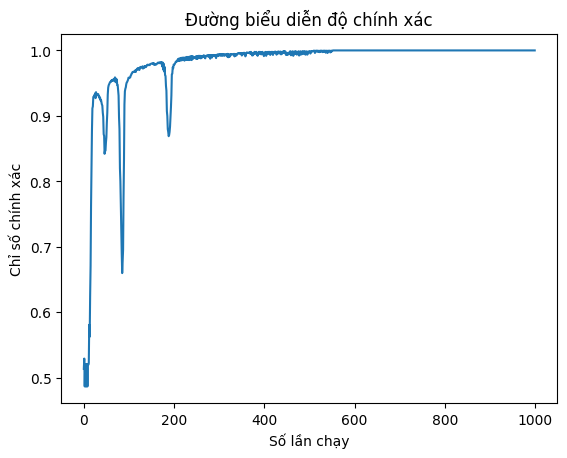

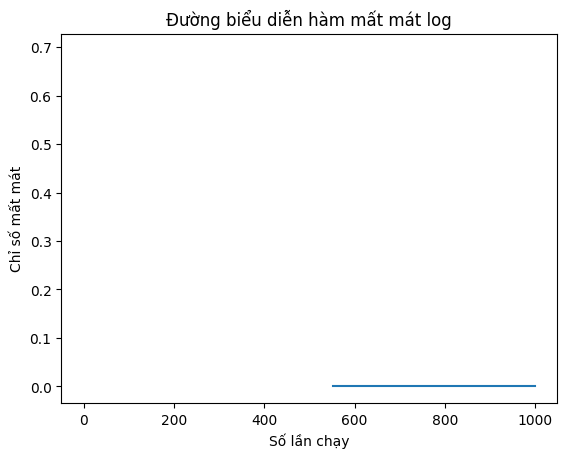

In [25]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_regression(X, y, alpha=0.01, num_iterations=1000):
    m, n = X.shape
    theta = np.zeros((n, 1))
    accuracy = []
    log_loss = []
    for i in range(num_iterations):
        z = np.dot(X, theta)
        h = sigmoid(z)
        J = (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        gradient = (1/m) * np.dot(X.T, (h - y))
        theta -= alpha * gradient
        y_pred = (h >= 0.5).astype(int)
        accuracy.append(np.mean(y_pred == y))
        log_loss.append(J)
    return theta, accuracy, log_loss

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Add bias term to X
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

# Train the model
theta, accuracy, log_loss = logistic_regression(X_train, y_train)

# Plot the accuracy and loss curves
import matplotlib.pyplot as plt

plt.plot(accuracy)
plt.title('Đường biểu diễn độ chính xác')
plt.xlabel('Số lần chạy')
plt.ylabel('Chỉ số chính xác')
plt.show()

plt.plot(log_loss)
plt.title('Đường biểu diễn hàm mất mát log')
plt.xlabel('Số lần chạy')
plt.ylabel('Chỉ số mất mát')
plt.show()

In [49]:
image = PAT001
image = image.reshape(image.shape[0],-1)
image.shape

(201, 262144)

In [45]:
import pickle

# Save the model to disk and reload
filename = '../../model/training/models/logreg_model.sav'
pickle.dump(logreg, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))

In [50]:
y_pred = loaded_model.predict(image)
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
start = end = 0

for index, value in enumerate(y_pred):
    if value == 1:
        start = index
        while y_pred[index] == 1:
            index += 1
        end = index
        break
        
start, end

(59, 174)

#### Tạo pipeline hoàn chỉnh

In [40]:
def filtering(image):
    # Load model
    filename = '../../model/training/models/logreg_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    
    # Predict
    temp = image.reshape(image.shape[0],-1)
    y_pred = loaded_model.predict(temp)
    
    # filtering
    start = end = 0
    for index, value in enumerate(y_pred):
        if value == 1:
            start = index
            while y_pred[index] == 1:
                index += 1
            end = index
            break
            
    image = image[start:end]
    return image

PAT001 = filtering(PAT001)
PAT001.shape

(115, 512, 512)

In [ ]:
# Giảm thiểu các tấm ảnh nhiễu rất nhiều
explore_3D_array(PAT001)

#### 2.2 Huấn luyện mô hình với Tensorflow

In [13]:
# Normalize data
X_max = 1024
X_min = -1024

X = (X - X_min) / (X_max - X_min)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((2751, 512, 512),
 (619, 512, 512),
 (69, 512, 512),
 (2751, 1),
 (619, 1),
 (69, 1))

In [22]:
# Reshape the data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1) # Reshape the validation data

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), validation_split=0.1) # Add the validation data and split

Epoch 1/5
86/86 [==============================] - 9s 102ms/step - loss: 2.5490 - accuracy: 0.8302 - val_loss: 0.6372 - val_accuracy: 0.8406
Epoch 2/5
86/86 [==============================] - 8s 91ms/step - loss: 0.2875 - accuracy: 0.9248 - val_loss: 0.1223 - val_accuracy: 0.9565
Epoch 3/5
86/86 [==============================] - 8s 96ms/step - loss: 0.2406 - accuracy: 0.9462 - val_loss: 0.0810 - val_accuracy: 0.9565
Epoch 4/5
86/86 [==============================] - 8s 97ms/step - loss: 0.0691 - accuracy: 0.9756 - val_loss: 0.0322 - val_accuracy: 0.9855
Epoch 5/5
86/86 [==============================] - 8s 92ms/step - loss: 0.1126 - accuracy: 0.9622 - val_loss: 0.2773 - val_accuracy: 0.9420


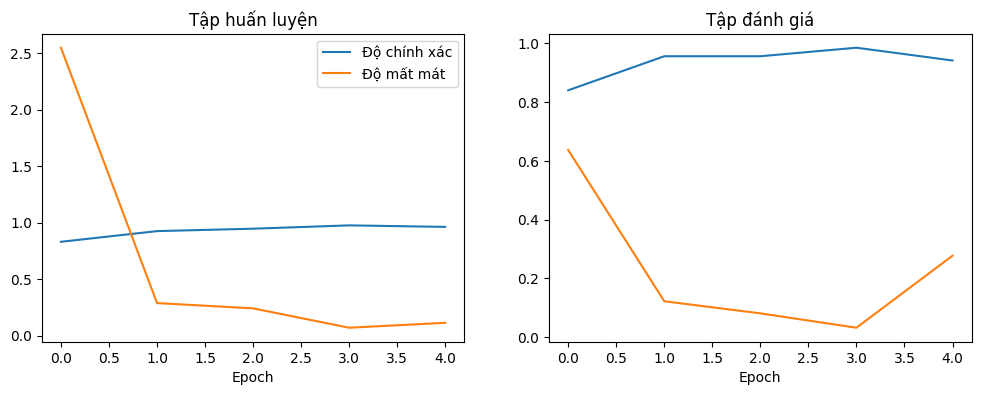

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Tập huấn luyện')
plt.plot(history.history['accuracy'], label='Độ chính xác')
plt.plot(history.history['loss'], label='Độ mất mát')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('Tập đánh giá')
plt.plot(history.history['val_accuracy'], label='Độ chính xác')
plt.plot(history.history['val_loss'], label='Độ mất mát')
plt.xlabel('Epoch')

plt.show()

In [26]:
model.save('../../model/training/models/binary_tensor.h5')

d:\Documents\GitHub\VascuIAR\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
load_model_tensor = tf.keras.models.load_model('../../model/training/models/binary_tensor.h5')

In [30]:
PAT001 = PAT001.reshape(PAT001.shape[0], -1)
y_pred = load_model_tensor.predict(PAT001)
len(y_pred)

7/7 [==============================] - 0s 12ms/step


201

### 3. Cắt tròn với phương trình đường tròn và lưu

In [6]:
ban_kinh = 190
a = b = 512/2

left = top = a - ban_kinh
right = bottom = a + ban_kinh

def euclidian_distance(x, y, a, b):
    dis = ((x - a)**2 + (y - b)**2)**(1/2)
    return dis

crop_imgs = []
def circling():
    for index in range(PAT001.shape[0]):
        img = PAT001[index]
        for x in range(PAT001.shape[1]):
            for y in range(PAT001.shape[2]):
                if euclidian_distance(x, y, a, b) > ban_kinh:
                    img[x,y] = -2000
        img = img[int(top) : int(bottom), int(left) : int(right)]
        crop_imgs.append(img)
        
circling()
crop_imgs = np.array(crop_imgs)
crop_imgs.shape

(201, 380, 380)

In [ ]:
PAT001 = crop_imgs
explore_3D_array(PAT001)

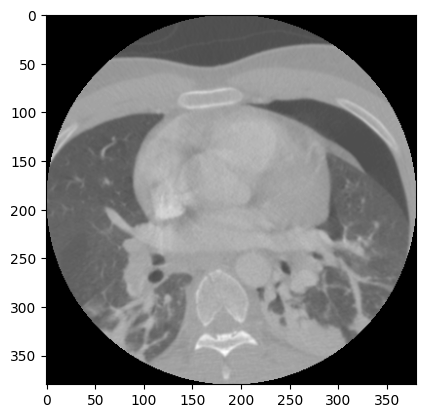

In [8]:
plt.imshow(PAT001[100], cmap="gray")

##### Lưu lại dưới định dạng .nii.gz

In [9]:
out_path = '../../data/PatientsDCM/PAT001/PAT001.nii.gz'
converted_array = np.array(PAT001, dtype=np.float32)
converted_array = np.transpose(converted_array, (2, 1, 0))

affine = np.eye(4)
nifti_file = nib.Nifti1Image(converted_array, affine)
nib.save(nifti_file, out_path)

# reread to check
raw_img_sitk = sitk.ReadImage(out_path, sitk.sitkFloat32)
raw_img_sitk = sitk.GetArrayFromImage(raw_img_sitk)
print(f'Shape of numpy array: {raw_img_sitk.shape}')

Shape of numpy array: (201, 380, 380)


In [ ]:
explore_3D_array_comparison(raw_img_sitk, PAT001)

### 4. Xem và Normalize đơn vị Housefield

Đơn vị Hounsfield (HU) là một đơn vị được sử dụng để thể hiện mật độ phóng xạ của vật liệu trong chụp cắt lớp vi tính (CT). Thang đo HU dựa trên mật độ phóng xạ của không khí và nước, được gán các giá trị lần lượt là -1000 HU và 0 HU. Thang đo HU dao động từ -1000 HU đối với không khí đến +3000 HU đối với xương hoặc kim loại rất dày đặc.  Các vật liệu và mô khác nhau có giá trị HU khác nhau, có thể giúp xác định và phân biệt chúng trên hình ảnh CT.

3071 -2000


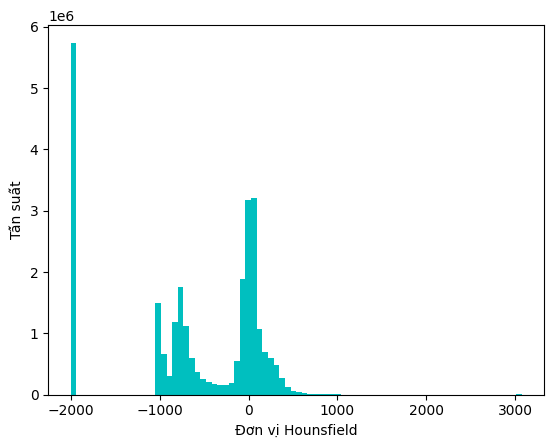

In [80]:
print(np.max(PAT001), np.min(PAT001))

plt.hist(PAT001.flatten(), bins=80, color='c')
plt.xlabel("Đơn vị Hounsfield")
plt.ylabel("Tấn suất")
plt.show()

Tuy nhiên range Hounsfield Unit ở trên chưa chính xác trong vùng hình tròn và có một vài nhiễu +3000

In [85]:
def normalization():
    max_val = min_val = 0
    # Find max min
    for index in range(PAT001.shape[0]):
            img = PAT001[index]
            for x in range(PAT001.shape[1]):
                for y in range(PAT001.shape[2]):
                    if euclidian_distance(x, y, a=PAT001.shape[1]/2, b=PAT001.shape[1]/2) <= ban_kinh: # nằm trong hình tròn
                        if img[x,y] > max_val:
                            max_val = img[x,y] 
                        elif img[x,y] < max_val:
                            min_val = img[x,y] 
    # Intensity normalization                        
    for index in range(PAT001.shape[0]):
        img = PAT001[index]
        for x in range(PAT001.shape[1]):
            for y in range(PAT001.shape[2]):
                if euclidian_distance(x, y, a=PAT001.shape[1]/2, b=PAT001.shape[1]/2) <= ban_kinh: # nằm trong hình tròn
                    img = (img - min_val) / (max_val - min_val)
                    PAT001[index] = img

(3071, -878)

Hoặc Normalize với range tùy chọn

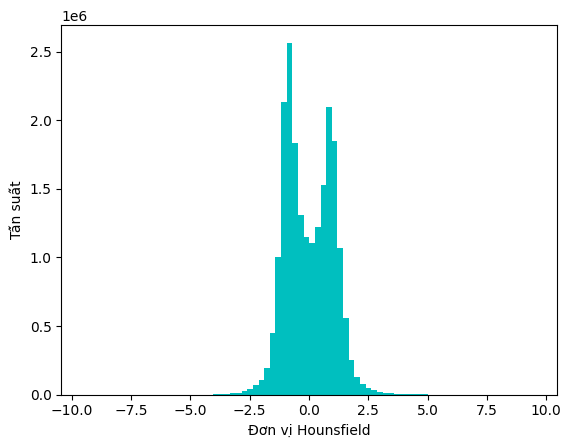

In [88]:
from scipy import stats

in_range = (-1024, 1024)
mask = (PAT001 >= in_range [0]) & (PAT001 <= in_range [1])
masked_array = np.ma.masked_array (PAT001, ~mask)
normalized_array = stats.zscore (masked_array, axis = 0)
normalized_array = normalized_array.filled (0)

plt.hist(normalized_array.flatten(), bins=80, color='c')
plt.xlabel("Đơn vị Hounsfield")
plt.ylabel("Tấn suất")
plt.show()

Lưu ý: Bước normalization chỉ thực hiện khi muốn train một model nào đó

### 5. Toàn bộ code chạy một lần các các bộ PAT khác nhau

#### Các hàm hỗ trợ

In [2]:
INPUT_FOLDER = '../../data/PatientsDCM/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

def load_scan(path):
    slices = [dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)  
    return np.array(image, dtype=np.int16)

def euclidian_distance(x, y, a, b):
    dis = ((x - a)**2 + (y - b)**2)**(1/2)
    return dis

def filtering(image):
    # Load model
    filename = '../../model/training/models/logreg_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
        
    # Predict
    temp = image.reshape(image.shape[0],-1)
    y_pred = loaded_model.predict(temp)
        
    # filtering
    start = end = 0
    for index, value in enumerate(y_pred):
        if value == 1:
            start = index
            while y_pred[index] == 1 and index < image.shape[0] - 1:
                index += 1
            end = index
            break
                
    image = image[start:end]
    return image

#### Code chạy chính

In [4]:
def run(index_PAT):
    # Read the volumetric images
    PAT_scan = load_scan(INPUT_FOLDER + patients[index_PAT - 1])
    PAT = get_pixels_hu(PAT_scan)
    
    # Filtering with logistic regression
    PAT = filtering(PAT)

    # Circling and clipping
    ban_kinh = 190
    a = b = 512/2
    left = top = a - ban_kinh
    right = bottom = a + ban_kinh
    crop_imgs = []

    for index in range(PAT.shape[0]):
        img = PAT[index]
        for x in range(PAT.shape[1]):
            for y in range(PAT.shape[2]):
                if euclidian_distance(x, y, a, b) > ban_kinh:
                    img[x,y] = -2000
        img = img[int(top) : int(bottom), int(left) : int(right)]
        crop_imgs.append(img)
    crop_imgs = np.array(crop_imgs)
    
    # Save into .nii.gz file
    index_PAT = '00' + str(index_PAT) if index_PAT < 10 else '0' + str(index_PAT)
    out_path = f'../../data/PatientsDCM/Postprocessing/PAT{index_PAT}.nii.gz'
    converted_array = np.array(crop_imgs, dtype=np.float32)
    converted_array = np.transpose(converted_array, (2, 1, 0))
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)
    nib.save(nifti_file, out_path)
    
    # Done line
    print(f'{index_PAT} done!')

# Loop through all patients
for index_PAT in range(1, 17, 1):
    run(index_PAT)

001 done!
002 done!
003 done!
004 done!
005 done!
006 done!
007 done!
008 done!
009 done!
010 done!
011 done!
012 done!
013 done!
014 done!
015 done!
016 done!


### 6. Kiểm tra kết quả

In [ ]:
img = sitk.ReadImage('../../data/PatientsDCM/Postprocessing/PAT004.nii.gz', sitk.sitkFloat32)
img = sitk.GetArrayFromImage(img)
explore_3D_array(img)